In [2]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import k_fold_cross_validation as cv
import mlp_backprop_momentum as mlp

%matplotlib inline

In [3]:
PATH = './voice_recognition/vowels/'

In [4]:

def read(files):
    values = []
    
    for file in files:
        values.append(wav.read(os.path.join(PATH, file)))
    
    return values
    
def generate_mfcc(files):
    mfcc_array = []
    for (rate, X) in files:
        mfcc_array.append(mfcc(X, samplerate=rate, nfft=1024))
        
    return mfcc_array

def mean_compute(mfcc):
    values = []
    
    for feature in mfcc:
        mean = np.mean(feature,axis=0)
        values.append(mean)
    return values
    
def scale(array, min, max):
    nom = (array-array.min(axis=0))*(max-min)
    denom = array.max(axis=0) - array.min(axis=0)
    denom[denom==0] = 1
    return min + nom/denom

def std_compute(mfcc):
    values = []
    
    for feature in mfcc:
        deviation = np.std(feature,axis=0)
        values.append(deviation)
    return values

def median_compute(mfcc):
    values = []
    
    for feature in mfcc:
        median = np.median(feature,axis=0)
        values.append(median)
    return values


In [5]:
men = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and (file.startswith('nam') or file.startswith('sam')) and file.endswith('.wav'))]

women = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and (file.startswith('naf') or file.startswith('saf')) and file.endswith('.wav'))]

In [6]:
men_data = read(men)
women_data= read(women)
    
men_mfcc = generate_mfcc(men_data)
women_mfcc = generate_mfcc(women_data)

men_feature = mean_compute(men_mfcc)
women_feature = mean_compute(women_mfcc)


In [7]:
values = []
WOMAN = [1]
MAN = [-1]

for value in women_feature:
    values.append(np.append(value, WOMAN))
    
for value in men_feature:
    values.append(np.append(value, MAN))
    
values = scale(np.asarray(values), -1, 1)

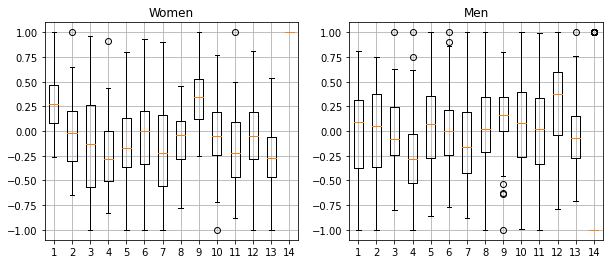

In [8]:
pl.figure(figsize=(10,4))
pl.subplot(1,2,1)
pl.boxplot(values[:50])
pl.title('Women')
pl.grid()


pl.subplot(1,2,2)
pl.boxplot(values[50:])
pl.title('Men')
pl.grid()

In [9]:
NB_NEURONS = [2, 4, 8, 16, 32]
LEARN_RATE = 0.001
MOMENTUM = 0.5
NUM_INITS = 10
EPOCHS = 1000

input = values[:,0:13]
output = values[:,13]

MSE = np.zeros((len(NB_NEURONS), NUM_INITS, EPOCHS))

print('TEST BEGIN')                                
for i_h, h in enumerate(NB_NEURONS):     
    print('Test with : ', h, 'neurons in hidden layer')
    
    layer = mlp.MLP([13, h, 1], 'tanh')
    for i in np.arange(NUM_INITS):                                      
        layer.init_weights()
        
        MSE[i_h, i, :] = layer.fit((input, output),
                                learning_rate=LEARN_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

TEST BEGIN
Test with :  2 neurons in hidden layer
Test with :  4 neurons in hidden layer
Test with :  8 neurons in hidden layer
Test with :  16 neurons in hidden layer
Test with :  32 neurons in hidden layer


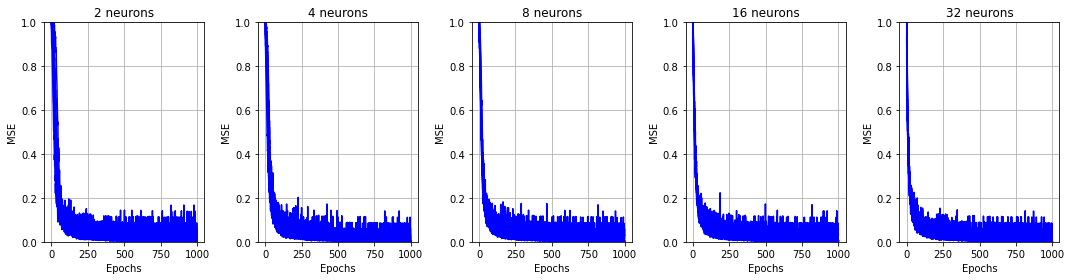

In [10]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(NB_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In [11]:
K = 5
EPOCHS = 600
NB_TESTS = 8
NB_NEURONS = [2, 5, 10, 20, 30, 45]

In [12]:
test_set = np.zeros((len(NB_NEURONS), EPOCHS, NB_TESTS))
train_set = np.zeros((len(NB_NEURONS), EPOCHS, NB_TESTS))

for i_h, h in enumerate(NB_NEURONS):          # number of neurons in hidden layer                           
    print('Test with : ', h, 'neurons in hidden layer')
    layer = mlp.MLP([13, h, 1], 'tanh')
    for i in np.arange(NB_TESTS):                          # number of tests             
        layer.init_weights()                                   # initialize weights            
        val1, val2 = cv.k_fold_cross_validation_per_epoch(layer,         # perform k-fold cross validation
                                                            values,      # data
                                                            k=K,        # number of folds
                                                            learning_rate=LEARN_RATE, # learning rate
                                                            momentum=MOMENTUM,  # momentum
                                                            epochs=EPOCHS) # number of epochs
        train_set[i_h, :, i] = val1
        test_set[i_h, :, i] = val2

Test with :  2 neurons in hidden layer
Test with :  5 neurons in hidden layer
Test with :  10 neurons in hidden layer
Test with :  20 neurons in hidden layer
Test with :  30 neurons in hidden layer
Test with :  45 neurons in hidden layer


In [13]:
mean_train_set = np.mean(train_set, axis=2)
mean_test_set = np.mean(test_set, axis=2)
sd_train_set = np.std(train_set, axis=2)
sd_test_set = np.std(test_set, axis=2)

v_min = min(np.min(mean_train_set), np.min(mean_test_set))
v_max = max(np.max(mean_train_set), np.max(mean_test_set))

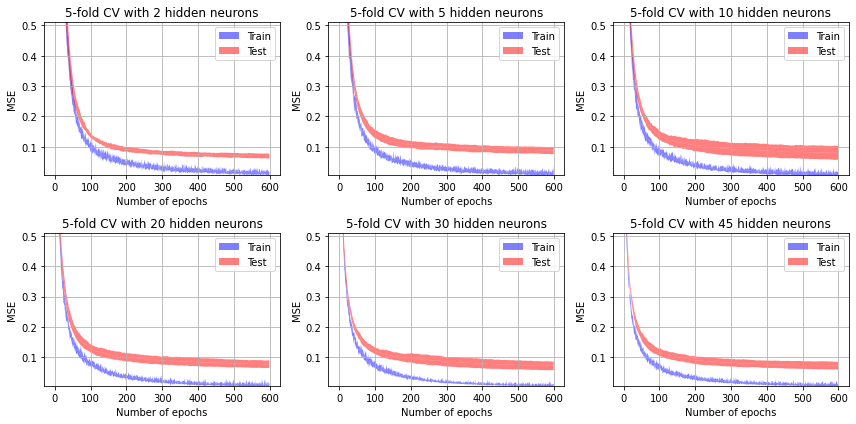

In [14]:

n_rows = int(np.ceil(len(NB_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(NB_NEURONS):
    pl.subplot(n_rows, min(3, len(NB_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), mean_train_set[i_n,:], mean_train_set[i_n,:]+sd_train_set[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), mean_train_set[i_n,:], mean_train_set[i_n,:]-sd_train_set[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), mean_test_set[i_n,:], mean_test_set[i_n,:]+sd_test_set[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), mean_test_set[i_n,:], mean_test_set[i_n,:]-sd_test_set[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

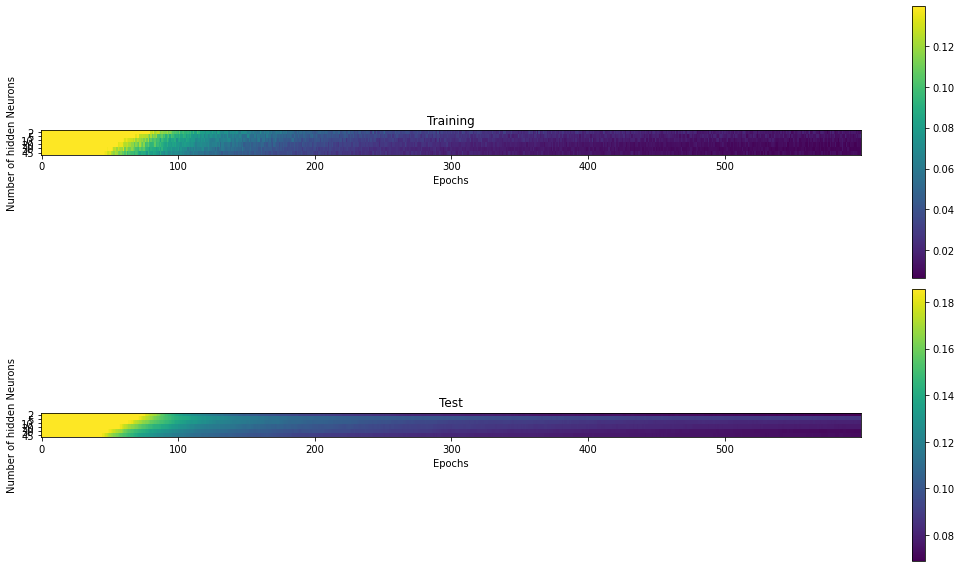

In [15]:
# Display the train set
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(mean_train_set, vmin=np.min(mean_train_set), vmax=np.percentile(mean_train_set, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(NB_NEURONS)), NB_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()

# Display the test set
pl.subplot(2,1,2)
pl.imshow(mean_test_set, vmin=np.min(mean_test_set), vmax=np.percentile(mean_test_set, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(NB_NEURONS)), NB_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

In [16]:
K = 5
LEARN_RATE = 0.001
MOMENTUM = 0.5
EPOCHS = 500
NB_NEURONS = 25

b_MSE_train = 2 # best MSE train
b_MSE_test = 2 # best MSE test
b_f_score = 2 # best f-score

w_MSE_train = -1 # worst MSE train
w_MSE_test = -1 # worst MSE test
w_f_score = -1 # worst f-score

w_conf_mat = np.zeros((2, 2)) # worst confusion matrix
b_conf_mat = np.zeros((2, 2)) # best confusion matrix
total_results = np.zeros((2, 2))

mean_train_set = 0
mean_test_set = 0

In [17]:
nn = mlp.MLP([13, NB_NEURONS, 1], 'tanh')

for i in range(0, 100):
    MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                               values,
                                                               k=K,
                                                               learning_rate=LEARN_RATE,
                                                               momentum=MOMENTUM,
                                                               epochs=EPOCHS,
                                                               threshold=0.0)
    if b_MSE_train > MSE_train:
        b_MSE_train = MSE_train
    elif w_MSE_train < MSE_train:
        w_MSE_train = MSE_train
        
    if b_MSE_test > MSE_test:
        b_MSE_test = MSE_test
    elif w_MSE_test < MSE_test:
        w_MSE_test = MSE_test
    
    for j in range(0, 2):
        for k in range(0, 2):
            total_results[j][k] += conf_mat[j][k]
    
    mean_train_set += MSE_train
    mean_test_set += MSE_test
        
    if b_conf_mat[0][0] + b_conf_mat[1][1] < conf_mat[0][0] + conf_mat[1][1]:
        best_conf_mat = conf_mat
    elif w_conf_mat[0][1] + w_conf_mat[1][0] < conf_mat[0][1] + conf_mat[1][0]:
        worst_conf_mat = conf_mat

KeyboardInterrupt: 

In [ ]:
print("Worst MSE training: ".ljust(20, ' '), w_MSE_train)
print("Best MSE training: ".ljust(20, ' '), b_MSE_train)
print("Mean MSE training: ".ljust(20, ' '), mean_train_set/100)
print("\nWorst MSE test: ".ljust(20, ' '), w_MSE_test)
print("Best MSE test: ".ljust(20, ' '), b_MSE_test)
print("Mean MSE training: ".ljust(20, ' '), mean_test_set/100)
print("\nBest confusion matrix:")
print(b_conf_mat)
print("\nWorst confusion matrix:")
print(w_conf_mat)

for i in range(0, 2):
    for j in range(0, 2):
        total_results[i][j] /= 100

print("\nMean matrix:")
print(total_results)

# precision = tp/(tp + fp)
mean_precision = total_results[0][0] / (total_results[0][0] + total_results[1][0])
print("\nMean precision: ".ljust(21, ' '), mean_precision)

# recall = tp/(tp + fn)
mean_recall = total_results[0][0] / (total_results[0][0] + total_results[0][1])
print("Mean recall: ".ljust(20, ' '), mean_recall)

# F1 Score = 2 x precision x recall / ( precision + recall)
mean_f1 = 2 * mean_precision * mean_recall / (mean_precision + mean_recall)
print("Mean F1 Score: ".ljust(20, ' '), mean_f1)

Worst MSE training:  -1
Best MSE training:   2
Mean MSE training:   0.0

Worst MSE test:     -1
Best MSE test:       2
Mean MSE training:   0.0

Best confusion matrix:
[[0. 0.]
 [0. 0.]]

Worst confusion matrix:
[[0. 0.]
 [0. 0.]]

Mean matrix:
[[0. 0.]
 [0. 0.]]

Mean precision:      nan
Mean recall:         nan
Mean F1 Score:       nan


/var/folders/4h/248lt3rn0kqgsrsk11k0bc_40000gn/T/ipykernel_41202/44810578.py:20: RuntimeWarning: invalid value encountered in double_scalars
  mean_precision = total_results[0][0] / (total_results[0][0] + total_results[1][0])
/var/folders/4h/248lt3rn0kqgsrsk11k0bc_40000gn/T/ipykernel_41202/44810578.py:24: RuntimeWarning: invalid value encountered in double_scalars
  mean_recall = total_results[0][0] / (total_results[0][0] + total_results[0][1])
